In [14]:
import pickle
import torch

from garage.experiment.deterministic import set_seed
from garage.envs.point_env import PointEnv
from src.utils import GarageToGymWrapper
from stable_baselines3 import SAC

SEED=42
N_TASKS=4

set_seed(SEED)
CircleRotation=PointEnv()
train_goal_locations=CircleRotation.sample_tasks(N_TASKS)

task_idx=0
task_0=PointEnv()
task_0.set_task(train_goal_locations[task_idx])
task_0_gym=GarageToGymWrapper(task_0)

data_dir:str="data/local/experiment/circle_rotation"
policy_dir:str=data_dir+"/sac_circle_rotation_task_0.zip"
replay_buffer_dir:str=data_dir+"/sac_circle_rotation_task_0_replay_buffer.pkl"
policy_base = SAC.load(policy_dir,env=task_0_gym)
buffer=pickle.load(open(replay_buffer_dir, "rb"))

train_goal_locations=[
    {'goal': torch.tensor([-0.70506063,  0.70914702])},
 {'goal': torch.tensor([ 0.95243384, -0.30474544])},
 {'goal': torch.tensor([-0.11289421, -0.99360701])},
 {'goal': torch.tensor([-0.81394263, -0.58094525])}]



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(
/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [114]:
policy_dir

'data/local/experiment/circle_rotation/sac_circle_rotation_task_0.zip'

In [113]:
torch.load(policy_dir)

RuntimeError: [enforce fail at inline_container.cc:166] . file in archive is not in a subdirectory: data

In [24]:
def rotation_vector_field(p_batch: torch.tensor, center)->torch.tensor:
    """Returns kernel samples at batched points p from a task."""

    _generator=torch.tensor([[0, -1], [1,0]], requires_grad=False, dtype=torch.float32).unsqueeze(0)
    projected_state = p_batch-center
    return torch.einsum("dmn, bn->bdm", _generator, projected_state)

points=torch.randn(100, 2, requires_grad=False, dtype=torch.float32)
rotated_points=rotation_vector_field(points, train_goal_locations[task_idx]["goal"]).squeeze(1)

In [60]:
points=torch.randn(100, 2, requires_grad=False, dtype=torch.float32)

W_star = torch.tensor([[0.0, -1.0], [1.0,0.0]])
encoder = lambda p: p - train_goal_locations[task_idx]["goal"]
decoder = lambda p: p + train_goal_locations[task_idx]["goal"]

rotated_points = decoder((W_star @ encoder(points).T).T)

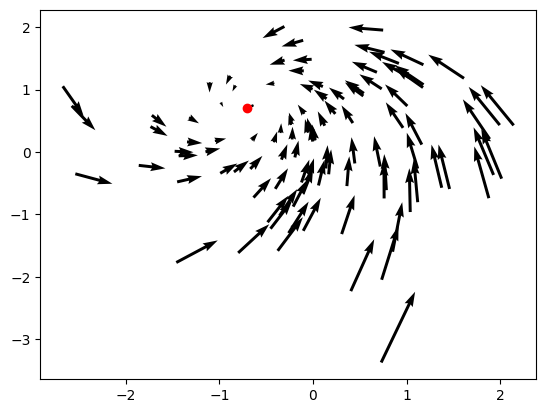

In [64]:
import matplotlib.pyplot as plt

U = rotated_points[:,0] - points[:,0]
V = rotated_points[:,1] - points[:,1]

plt.quiver(points[:,0].numpy(),
           points[:,1].numpy(),
           U.numpy(), V.numpy())
plt.plot(train_goal_locations[task_idx]["goal"][0].item(), train_goal_locations[task_idx]["goal"][1].item(), 'ro')

In [ ]:
policy_base.policy.extract_features()

In [111]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.distributions import SquashedDiagGaussianDistribution

# assume `model` is your SB3 model, e.g. PPO("MlpPolicy", …), already .to(device)

def diff_predict(model, obs: torch.tensor):
    """Predicts the mean action for a given observation using the model's policy."""
    feat_ext = model.policy.features_extractor  
    features = model.policy.extract_features(obs, feat_ext)
    latent_pi, _ = model.policy.mlp_extractor(features)
    mean_actions = model.policy.action_net(latent_pi)

    return mean_actions

In [112]:
diff_predict(policy_base, torch.randn(1, 2, requires_grad=False, dtype=torch.float32))

TypeError: 'NoneType' object is not callable

In [104]:
ACTION_DIM=2
LIE_DIM=1
N_EPOCHS=1000
BATCH_SIZE=64
W_A_init=torch.randn(size=(LIE_DIM, ACTION_DIM, ACTION_DIM), requires_grad=True, dtype=torch.float32)
obs=buffer.observations.reshape(1_000_000, 2)
W_star = torch.tensor([[0.0, -1.0], [1.0,0.0]]).unsqueeze(0)


def equivar_geo_loss(W_A,
                     replay_buffer_states: torch.tensor):
    """Computes the loss of the equivariant geometric loss."""
    # Sample a batch from the replay buffer
    W_A_optim=torch.optim.Adam([W_A], lr=1e-3)

    _idxs= torch.randint(0, len(buffer.observations), (BATCH_SIZE,))
    states = replay_buffer_states[_idxs]
    c = torch.normal(torch.ones(BATCH_SIZE), std=0.1).unsqueeze(1)

    # 1. Sample S left-actions, transform states.
    states_tilde = encoder(states)
    g_S = torch.matrix_exp(torch.einsum("bd,dmn->bmn", c, W_star))
    g_states_tilde = torch.einsum("bmn, bn->bm", g_S, states_tilde)
    untilde_g_states_tilde = decoder(g_states_tilde)
    actions_g = diff_predict(policy_base, untilde_g_states_tilde)

    # 2. Sample A left-actions, transform actions.
    g_A = torch.matrix_exp(torch.einsum("bd,dmn->bmn", c, W_A))
    actions = diff_predict(policy_base, states)
    g_actions = torch.einsum("bmn, bn->bm", g_A, actions)

    # 3. Compute the loss.
    loss = torch.mean((g_actions - actions_g) ** 2)

    # 4. Backpropagate the loss.
    W_A_optim.zero_grad()
    loss.backward()
    W_A_optim.step()

    return loss

for _ in range(N_EPOCHS):
    loss = equivar_geo_loss(W_A_init, torch.tensor(obs, dtype=torch.float32))
    print(f"Loss: {loss.item()}")

TypeError: 'NoneType' object is not callable

In [75]:
actions, _=policy_base.predict(rotated_points, deterministic=True)
actions.shape

(100, 2)